In [1]:
import numpy as np

import ngsolve 
from ngsolve.webgui import Draw
import netgen.geom2d

import copy

### The complex Ginzburg-Landau model on a different mesh in ngsolve

There are various forms of the complex Ginzburg-Landau equation for a field $A \in \mathbb{C}$.

From Cross' book
$$\partial_t A = A + (1 + i c_1) \nabla^2 A - (1-ic_3) |A|^2 A$$

From https://codeinthehole.com/tutorial/index.html  (Winterbottom) 
$$\partial_t A = A + (1 + i \alpha) \nabla^2 A - (1+ i\beta) |A|^2 A$$

These two  are the same if you send $\alpha \to c_1$ and
 $\beta \to - c_3$. 

from Chat\'e's and Manneville's 1996  review https://arxiv.org/abs/1608.07519
$$\partial_t A = A + (1 + i b_1) \nabla^2 A - (b_3-i) |A|^2 A$$

The real Ginzburg-Landau equation is setting $c_1, c_3=0$ of the Cross form or $\alpha=\beta=0$ of the Winterbottom form.
$$\partial_t A = A  + \nabla^2A - |A|^2 A$$

To rescale space you can multiply the Laplacian term by a factor.

In these forms the domain typically has size a few hundred so that interesting phenomena is seen. 
It is somewhat tedious to convert between Chate's form and the other two, but an advantage of 
that form is that they have conveniently classified the different behaviors as a function of $b_1, b_3$. 

The PDE  is obeyed in the domain $\Omega$, 
but on the boundary  $\partial \Omega$ we set $\frac{\partial A}{\partial n} = 0 $. 
This is a Neumann boundary condition. 

The weak/variational form of the problem is 
\begin{align}
\int_\Omega \partial_t u\ w\ dx = \int_\Omega D_u (\Delta u) w \ dx + \int_\Omega g(u) \ w \ dx
\end{align}
with function $$g(u) = u-(1 + i\beta)|u|^2 u, \qquad {\rm or} \qquad  
g(u) = u - (b_3 - i ) |u|^2 u$$ depending upon which form of the equation one wants to use. 

The diffusion coefficient $D_u = (1 + i \alpha)$, 
and for all test functions $w \in \hat V$.  
We integrate by parts the terms that contain a Laplacian operator 
\begin{align}
\int_\Omega \partial_t u\ w \ dx =   - D_u  \int_\Omega \nabla u \nabla w \ dx 
+ D_u\int_{\partial \Omega} \nabla u\ w \ ds
+ \int_\Omega g(u) \ w \ dx 
\end{align}
With normal derivative of $u$ equal to zero on the boundary, the  boundary terms in the above
equations can be neglected.
The weak form should be obeyed for all test functions $w \in \hat V$ with $\hat V = H^1(\Omega)$.
Since we lack Dirichlet regions of the boundary, there is no additional condition on $\hat V$. 
 We are following section 2.2.1 of the Fenics book.

We use a discrete subspace for $\hat V$ and assume we have a nice basis for it. 
We write each term as if it were an operator acting on a vector $w$ (aka the test function) in this basis. 

We split each time step into two pieces.  First updating $u,v$ with an implicit Crank-Nicolson step and 
then we take a first order forward Eulerian step to take into account the function $g$. 

The Crank-Nicolson step for  $\partial_t u = F u  $  with $F$ a linear op is the following scheme 
\begin{align}
\partial_t u \sim \frac{u^{n+1} - u^n}{\Delta t} = \frac{1}{2} \left(F u^{n+1} + F u^n\right)
\end{align}
\begin{align}
\left( 1 - \frac{\Delta t F}{2 } \right) u^{n+1} = \left(1 + \frac{\Delta t F}{2 } \right) u^n \end{align}
\begin{align}
u^{n+1} = \left( 1 - \frac{ \Delta tF}{2} \right)^{-1} \left(1 + \frac{\Delta t F}{2 } \right)u^n
\end{align}
Taking into account the reaction equations for a diffusion reaction system 
\begin{align}
u^{n+1} &= \left( 1 - \frac{ \Delta t}{2 }D_u L \right)^{-1} \left(1 + \frac{\Delta t}{2 }D_uL  \right)u^n + 
\Delta t\ g(u^n)
\end{align}
where $L$ is the Laplacian operator. 
In the middle step we can add an subtract a term proportional to $u^n$ 
\begin{align}
\left( 1 - \frac{\Delta t F}{2 } \right) u^{n+1} = \left(1 - \frac{\Delta t F}{2 }  + \Delta t F \right) u^n 
\end{align}
This gives the incremental form 
\begin{align}
u^{n+1}  - u^n = \left( 1 - \frac{\Delta t F}{2 } \right)^{-1}   \left( \Delta t F \right) u^n
\end{align}
Restoring the non-linear term 
\begin{align}
u^{n+1}  - u^n = \left( 1 - \frac{\Delta t F}{2 } \right)^{-1}   \left( \Delta t F \right) u^n + \Delta t\ g(u^n)
\end{align}


Note: we could bring the $u$ term from the non-linear operator into the linear operator $L$ when we use the Crank Nicolson method. 



The 1s are replaced by the mass matrix when using finite element methods. 

We define bilinear operators
\begin{align}
m(u,v) = \int u v dx 
\end{align}
which is a matrix $m(u,:) = M$ on the finite element space.
The Laplacian operator $\int \Delta u v dx$ becomes 
$$-a(u,v) = -\int \nabla u \nabla v dx $$ and from this we construct the linear operator $$L = - a(:,v)$$ 

If we do a mixed scheme, we include the non-linear operator when we solve for $u^{n+1}$ or $u^{n+1} - u^n$.
With matrix operators $M, L$, the Crank Nicolson method gives
\begin{align}
\left( M - \frac{ \Delta t}{2 }D_u L \right) u^{n+1}  & = \left(M + \frac{\Delta t}{2 }D_uL  \right)u^n   + 
\Delta t\ g(u^n)
\\
u^{n+1} &= \left( M - \frac{ \Delta t}{2 }D_u L \right)^{-1} \left[ \left(M + \frac{\Delta t}{2 }D_uL  \right)u^n + 
\Delta t\ g(u^n) \right]
\end{align}
We can put this in incremental form by adding and subtracting $u^n$  
\begin{align}
\left( M - \frac{ \Delta t}{2 }D_u L \right)  u^{n+1} &= \left( M - \frac{ \Delta t}{2 }D_u L \right)u^n + \Delta t D_u L u^n 
 + \Delta t\ g(u^n)\\
u^{n+1} - u^n &= \left( M - \frac{ \Delta t}{2 }D_u L \right)^{-1}  \left[ D_u L u^n  +  g(u^n) \right] \Delta t 
\end{align}


An incremental Crank Nicolson followed by the non-linear term (an operator splitting) 
instead of mixed is this:
\begin{align}
u^{n+1} - u^n &= \left( M - \frac{ \Delta t}{2 }D_u L \right)^{-1}  \left( D_u L u^n   \right) \Delta t  +   g(u^n)\Delta t 
\end{align}

I found incremental version of CN worked fine, but the mixed method gave infinities.

In this notebook I try more than one way to do the non-linear term and I get similar results.
I also try order 2 and 3 and both give similar results. 
I did not get mixed methods with CN to work, though op split methods either incremental or replacing field worked. 

In [2]:
geo = netgen.geom2d.CSG2d()

# make a circle with a hole in it!
circle1 = netgen.geom2d.Circle( center=(0,0), radius=1.0,  bc="outer" )
circle2 = netgen.geom2d.Circle( center=(0.1,0), radius=0.3,  bc="inner" )

annulus = circle1 - circle2
fac = 100
annulus.Scale(150)
geo.Add(annulus)

# generate the  mesh
maxh_mesh = 0.03*fac  # max distance between nodes?
mesh = ngsolve.Mesh(geo.GenerateMesh(maxh=maxh_mesh))  # maxh here sets the scale of elements 
print(f"vertices={mesh.nv}, edges ={mesh.ne}")  # print numbers of vertices and edges!

Draw(mesh) # show the mesh

vertices=7925, edges =15438


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [3]:
# the extra nonlinear function: u is the field, b_3 is the free parameter 
def g(uu,b_3):
    return (uu-(b_3 -1j)*np.absolute(uu)*np.absolute(uu)*uu)   # Chate's form 
# this is used if carying out the non-linear term by hand

In [4]:
# creating a complex element from two real fields
Q = ngsolve.H1(mesh, order=2) 
#fes = ngsolve.H1(mesh, order=3, complex=True)  # We need a complex element
fes = Q*Q
#(ux,uy), (vx,vy) = fes.TnT() # trial and test functions!
#gfu = ngsolve.GridFunction(fes) # to hold the solution 


In [5]:
# create initial conditions!

# first get min and max of grid 
def get_range(mesh):
    xv = np.zeros(mesh.nv)
    yv = np.zeros(mesh.nv)
    k=0
    for v in mesh.vertices:
        xv[k] = v.point[0]
        yv[k] = v.point[1]
        k+= 1
    xxmax = np.max(xv)
    xxmin = np.min(xv)
    yymax = np.max(yv)
    yymin = np.min(yv)
    return xxmin,xxmax,yymin,yymax 

#xxmin,xxmax,yymin,yymax = get_range(mesh)  # relevant for generating seeds

# creates initial condition 
# arguments:
#   gfu: field on mesh for loading with initial conditions
#   nseeds: number of 1 seeds, 
#   sig: and a random dispersion for choosing random initial conditions 
#   h: a distance for width of peaks
# returns: 
#   nothing, gfu is set 
# globals:  
#   xxmin,xxmax,yymin,yymax to constrain random initial positions for seeds 
def gen_init(gfu,mesh,nseeds,sig,h):
    xxmin,xxmax,yymin,yymax = get_range(mesh) 

    A_r = gfu.components[0]
    A_i = gfu.components[1]
    r1  = A_r.vec.CreateVector()  # create a vector, consistent with gfu
    r1.SetRandom(); # fill with random complex numbers 
    r1 = sig*r1  # scale by sig
    r2  = A_i.vec.CreateVector()  # create a vector, consistent with gfu
    r2.SetRandom(); # fill with random complex numbers 
    r2 = sig*r2  # scale by sig
    ccf = 0.0  # will be a coefficient function 

    # seed with some 1 values 
    for k in range(nseeds):
        x_p = np.random.uniform(xxmin,xxmax)  # random position
        y_p = np.random.uniform(yymin,yymax)
        r2 = (ngsolve.x - x_p)*(ngsolve.x - x_p) + (ngsolve.y - y_p)*(ngsolve.y - y_p)
        ccf += ngsolve.exp(-0.5*r2/h**2)  # creates a coefficient function 

    A_r = gfu.components[0]
    A_i = gfu.components[1]
    A_r.Set(ccf)   # set the seeds into gfu
    A_i.Set(0.0) 
    A_r.vec.data += r1  # add randoms 
    #A_i.vec.data += r
    #return nothing

# make the norm from real and complex parts of the grid function 
def norm_gfu(gfu):
    A_r = gfu.components[0];  A_i = gfu.components[1]
    norm_A = ngsolve.sqrt(A_r*A_r + A_i * A_i)  # using coefficient function
    return norm_A

#  make an angle from real and complex components of the grid function, we want something that goes between 0 and 2pi
def theta_gfu(gfu):
    A_r = gfu.components[0]
    A_i = gfu.components[1]
    theta = ngsolve.atan(A_i/(A_r+1e-10))  # goes between -pi/2 and pi/2 
    theta2 = ngsolve.IfPos(A_r,theta,theta+np.pi)  # using coefficient functions
    theta3 = ngsolve.IfPos(theta2, theta2, theta2 + 2*np.pi)
    return theta3 
        
gfu = ngsolve.GridFunction(fes) # to hold the solution 
gen_init(gfu,mesh,40,1e-3,maxh_mesh)  # run it and then show it
Draw(norm_gfu(gfu),mesh)


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [6]:
# make assembled operators on the finite element space 
# arguments: 
#  fes: finite element space
#  alpha, parameter for model
#  dt timestep
# returns:
#   invastar, a_lap, b_op, minv operators needed for Crank Nicholson updates 
def mk_ops(fes,alpha,dt):
    (ux,uy), (vx,vy) = fes.TnT() # trial and test functions!
    #alpha = 2.  # must be defined here to make the Laplacian op    alpha = c_1 = b_1 of the different forms
    #D_u  = (1 + 1.j*alpha)  # complex diffusion coefficient, Chate form 
    #dt = .01    # timestep 

    # a = - Laplacian op is -L
    a_lap = ngsolve.BilinearForm(fes)  # holds Laplacian operator 
    a_lap +=         ngsolve.grad(ux)*ngsolve.grad(vx)*ngsolve.dx 
    a_lap +=         ngsolve.grad(uy)*ngsolve.grad(vy)*ngsolve.dx 
    a_lap += -alpha* ngsolve.grad(uy)*ngsolve.grad(vx)*ngsolve.dx 
    a_lap +=  alpha* ngsolve.grad(ux)*ngsolve.grad(vy)*ngsolve.dx 
    a_lap.Assemble()
    # needed for Crank Nicolson incremental update 

    # mass operator, needed for non-linear term incremental update  
    m = ngsolve.BilinearForm(fes)  # hold mass matrix 
    m += ux*vx*ngsolve.dx  + uy*vy*ngsolve.dx 
    m.Assemble()

    minv = m.mat.Inverse(freedofs=fes.FreeDofs())  # inverse!

    #print(f"m.mat.nze = {m.mat.nze}, a.mat.nze={a.mat.nze}") # check that they are the same
    # these are the number of nonzero elements in the sparse matrices

    # B = M - 0.5*L*dt , needed for non-incremental Crank Nicholson update L = -Laplacian times diffusion coeff, M = mass matrix
    b_op = m.mat.CreateMatrix()
    b_op.AsVector().data     = m.mat.AsVector() - 0.5*dt * a_lap.mat.AsVector()
    #print(f"b_op.nze = {b_op.nze}")

    # A* = M + 0.5 * L * dt   needed for Crank Nicholson update 
    astar = m.mat.CreateMatrix() # create a matrix in the form of m
    astar.AsVector().data = m.mat.AsVector() + 0.5*dt * a_lap.mat.AsVector()
    invastar = astar.Inverse(freedofs=fes.FreeDofs())
    #print(f"astar.nze={astar.nze}")

    return invastar, a_lap, b_op, minv  # return operators 

# the extra nonlinear function: u is the field, b_3 is the free parameter 
#def g(u,b_3):
#return (u-(b_3 -1j)*np.absolute(u)*np.absolute(u)*u)   # Chate's form 

# create an operator for the nonlinear function  
def mkgfun(fes,b_3):
    (ux,uy), (vx,vy) = fes.TnT() # trial and test functions!
    gfun = ngsolve.BilinearForm(fes,nonassemble=True)   # don't assemble so nonlinear part can be updated!
    gfun += ux*vx*ngsolve.dx + uy*vy*ngsolve.dx 
    gfun += (-b_3*ux - uy)*(ux*ux + uy*uy)*vx*ngsolve.dx  # Chate's form of PDE
    gfun += (-b_3*uy + ux)*(ux*ux + uy*uy)*vy*ngsolve.dx
    return gfun


In [17]:
# for running the integration
# op split, Crank Nicholson scheme, non incremental version 
#    (will be a problem if we use inhomogeneous Dirichlet boundary conditions)
# arguments:
#  fes: finite element space
#  gfu: grid function field output on finite element space 
#  scene: for drawing updates   output of Draw ngsolve.webgui
#  invastar, b_op,minv :      # matrix operators on the finite element system (used dt, alpha)
#  nsamples:  number of outputs to store in the multidimensional data set and to update in display
#  b_3: parameter for the complex Ginzburg Landau model (Chate form)
#  dt:        timestep  which was also used in the matrix operators invastar and b_op
#  gfun_op:  if True use a non-linear operator, if false compute non-linear function term by hand 
# returns 
#  gfut:   a multidimensional set of grid functions on finite element system that holds time stepped results
#           at different times 
#  globals: 
#   g() non-linear function 
def TimeStepping_CN(fes,gfu,scene, invastar, b_op, minv,  b_3, dt, initial_cond = None, t0 = 0, tend = 15, 
                 nsamples = 50,gfun_op = False):
    if initial_cond:
        gfu.Set(initial_cond)   # set initial condition, otherwise don't touch the initial fields 
        # as the initial condition could be set already in gfu.vec.data
    cnt = 0; time = t0
    sample_int = int(np.floor(tend / dt / nsamples)+1)  # nsamples is probably the number of outputs we want
    
    gfut = ngsolve.GridFunction(gfu.space,multidim=0)  # creates gfut
    gfut.AddMultiDimComponent(gfu.vec)  #  I think this makes it so we can store a series of solutions 

    if (gfun_op==False):
        A_r = gfu.components[0]
        A_i = gfu.components[1]

    if (gfun_op==True):
        gfun = mkgfun(fes,b_3)  # make the non-linear form 

    while (time < tend - 0.5 * dt):  # integrate until time is about equal to tend 

        #if (gfun_op==True):  # compute non-linear part, 
        #    gfun.Assemble()  # 
        
        res =  b_op * gfu.vec   # you can just multiply b onto gfu.vec (it is a matrix multiply!) # if b is just a matrix
        # res is defined here and is now a vector on the finite element system 
        gfu.vec.data = invastar * res  # replacing solution here for Crank Nicholson update  
        # note you can just multiply invastar onto res  (this is a matrix multiply!)

        # operator split add in non-linear part 
        if (gfun_op==True):
            gfun.Assemble()  # 
            res = dt*(gfun.mat*gfu.vec) 
            gfu.vec.data += minv*res    # 
        else:
            A_rpass = A_r.vec.FV().NumPy()[:]  # get the real part of the field 
            A_ipass = A_i.vec.FV().NumPy()[:]  # get the imaginary part 
            gfunv  = g(A_rpass + 1j*A_ipass,b_3) # compute the nonlinear term, is a numpy complex array
            A_r.vec.FV().NumPy()[:] += dt*np.real(gfunv) # add in non-linear function directly 
            A_i.vec.FV().NumPy()[:] += dt*np.imag(gfunv) # 
            
        print("\r",time,end="")
        if (cnt % sample_int == 0):
            #gfut.AddMultiDimComponent(gfu.vec)  ! notice not storing any data!!!!!!
            scene.Redraw()
        cnt += 1; time += dt
    return gfut

In [18]:

gfu = ngsolve.GridFunction(fes) # remake the field to hold the solution 
gen_init(gfu,mesh,60,1e-1,maxh_mesh)  # generate initial conditions nseeds and random components
scene=Draw(norm_gfu(gfu),mesh, settings = {  "Colormap" : { "ncolors" : 20 } , "Objects" : {"Wireframe" : False}})


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}, …

In [19]:
alpha = 2.; b_3 = 1.3 # choose a nice pattern 
dt = 0.06
invastar, a_lap, b_op, minv  = mk_ops(fes,alpha,dt)  # construct operators 
gfut_CN = TimeStepping_CN(fes,gfu,scene,invastar, b_op,minv,b_3, dt, t0=0,tend=60,gfun_op = False,nsamples=120)
# seems to work (by hand non-linear op)

 59.9599999999989045

In [20]:
gfu = ngsolve.GridFunction(fes) # remake the field to hold the solution 
gen_init(gfu,mesh,60,1e-1,maxh_mesh)  # generate initial conditions nseeds and random components
scene=Draw(norm_gfu(gfu),mesh, settings = {  "Colormap" : { "ncolors" : 20 } , "Objects" : {"Wireframe" : False}})


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}, …

In [22]:
alpha = 2.; b_3 = 1.3 # choose a nice pattern 
dt = 0.06
invastar, a_lap, b_op, minv  = mk_ops(fes,alpha,dt)  # construct operators 
gfut_CN = TimeStepping_CN(fes,gfu,scene,invastar, b_op,minv,b_3, dt, t0=0,tend=60,gfun_op = True,nsamples=120)
# also seems to work (non lin op) but takes longer to make a good pattern

craete bilinearformapplication
 59.940000000000766

In [8]:
# for running the integration
# incremental method Crank Nicolson op split
# arguments:
#  fes: finite element space
#  gfu: grid function field output on finite element space 
#  scene: for drawing updates   output of Draw ngsolve.webgui
#  invastar, a_lap,minv :      # matrix operators on the finite element system (used dt, alpha)
#  nsamples:  number of outputs to store in the multidimensional data set 
#  b_3: parameter for the complex ginzburg landau model (chate form)
#  dt:        timestep  which was also used in the matrix operators invastar 
#  gfun_op:  if True use a non-linear operator, if false compute non-linear term by hand 
# returns 
#  gfut:   a multidimensional set of grid functions on finite element system that holds time stepped results
#           at different times 
#  globals: 
#   g(),mkgfun(), non-linear functions 
def TimeStepping_MCN(fes,gfu,scene, invastar, a_lap, minv,  b_3, dt, initial_cond = None, t0 = 0, tend = 15, 
                 nsamples = 50,gfun_op = False):
    if initial_cond:
        gfu.Set(initial_cond)   # set initial condition, otherwise don't touch the initial fields 
        # as the initial condition could be set already in gfu.vec.data
    cnt = 0; time = t0
    sample_int = int(np.floor(tend / dt / nsamples)+1)  # nsamples is probably the number of outputs we want
    
    gfut = ngsolve.GridFunction(gfu.space,multidim=0)  # creates gfut
    gfut.AddMultiDimComponent(gfu.vec)  #  I think this makes it so we can store a series of solutions 

    if (gfun_op==False):
        A_r = gfu.components[0]
        A_i = gfu.components[1]
    
    if (gfun_op==True):
        gfun = mkgfun(fes,b_3)  # make the non-linear form 
        res = gfu.vec.CreateVector() # is a base vector 

    while (time < tend - 0.5 * dt):  # integrate until time is about equal to tend 

        res = gfu.vec.CreateVector() # is a base vector 
        res.data =  -dt*(a_lap.mat * gfu.vec)  # this is dt L u^n
        gfu.vec.data += invastar*res  # incremental version of Crank Nicolson on diffusive term only 
        
        #  now op split adding on non-linear term 
        if (gfun_op==True):
            gfun.Assemble()  # 
            res.data = dt*(gfun.mat*gfu.vec) # add in non-linear part
            gfu.vec.data += minv * res
           
        else:
            # by hand  
            A_rpass = A_r.vec.FV().NumPy()[:]  # get the real part of the field 
            A_ipass = A_i.vec.FV().NumPy()[:]  # get the imaginary part 
            gfunv  = dt*g(A_rpass + 1j*A_ipass,b_3) # compute the nonlinear term, has real and complex parts
            # in a numpy complex array 
            #gfu_temp = ngsolve.GridFunction(fes)
            #gfu_temp.components[0].vec.FV().NumPy()[:] = np.real(gfunv)
            #gfu_temp.components[1].vec.FV().NumPy()[:] = np.imag(gfunv)
            #gfu.vec.data += invastar*res  # increment trying a mixed method, nojoy
            #gfu.vec.data += invastar*gfu_temp.vec
            A_r.vec.FV().NumPy()[:] += np.real(gfunv) # add in non-linear function directly 
            A_i.vec.FV().NumPy()[:] += np.imag(gfunv) # 
            
        print("\r",time,end="")
        if (cnt % sample_int == 0):
            #gfut.AddMultiDimComponent(gfu.vec)  ! notice not storing any data!!!!!!
            scene.Redraw()
        cnt += 1; time += dt
    return gfut

In [119]:
gfu = ngsolve.GridFunction(fes) # remake the field to hold the solution 
gen_init(gfu,mesh,60,1e-1,maxh_mesh)  # generate initial conditions nseeds and random components
scene=Draw(norm_gfu(gfu),mesh, settings = {  "Colormap" : { "ncolors" : 20 } , "Objects" : {"Wireframe" : False}})


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}, …

In [120]:
alpha = 2.; b_3 = 1.3 # choose a nice pattern 
dt = 0.04
invastar, a_lap, b_op, minv  = mk_ops(fes,alpha,dt)  # construct operators 
gfut_CN = TimeStepping_MCN(fes,gfu,scene,invastar, a_lap,minv,b_3, dt, t0=0,tend=60,gfun_op = False,nsamples=120)
# also seems to work (non lin op)

 59.9599999999989045

In [121]:
gfu = ngsolve.GridFunction(fes) # remake the field to hold the solution 
gen_init(gfu,mesh,60,1e-1,maxh_mesh)  # generate initial conditions nseeds and random components
scene=Draw(norm_gfu(gfu),mesh, settings = {  "Colormap" : { "ncolors" : 20 } , "Objects" : {"Wireframe" : False}})


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}, …

In [125]:
alpha = 2.; b_3 = 1.3 # choose a nice pattern 
dt = 0.06
invastar, a_lap, b_op, minv  = mk_ops(fes,alpha,dt)  # construct operators 
gfut_CN = TimeStepping_MCN(fes,gfu,scene,invastar, a_lap,minv,b_3, dt, t0=0,tend=60,gfun_op = True,nsamples=120)
# also seems to work (non lin op)

craete bilinearformapplication
 59.940000000000766

In [9]:
# creating a complex element from two real fields
Q = ngsolve.H1(mesh, order=3) 
fes3 = Q*Q
#(ux,uy), (vx,vy) = fes.TnT() # trial and test functions!
#gfu = ngsolve.GridFunction(fes) # to hold the solution 


In [10]:
gfu = ngsolve.GridFunction(fes3) # remake the field to hold the solution 
gen_init(gfu,mesh,60,1e-1,maxh_mesh)  # generate initial conditions nseeds and random components
scene=Draw(norm_gfu(gfu),mesh, settings = {  "Colormap" : { "ncolors" : 20 } , "Objects" : {"Wireframe" : False}})


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}, …

In [11]:
alpha = 2.; b_3 = 1.3 # choose a nice pattern 
dt = 0.06
invastar, a_lap, b_op, minv  = mk_ops(fes3,alpha,dt)  # construct operators 
gfut_CN = TimeStepping_MCN(fes3,gfu,scene,invastar, a_lap,minv,b_3, dt, t0=0,tend=60,gfun_op = False,nsamples=120)


 59.940000000000766

In [12]:
gfu = ngsolve.GridFunction(fes3) # remake the field to hold the solution 
gen_init(gfu,mesh,60,1e-1,maxh_mesh)  # generate initial conditions nseeds and random components
scene=Draw(norm_gfu(gfu),mesh, settings = {  "Colormap" : { "ncolors" : 20 } , "Objects" : {"Wireframe" : False}})


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}, …

In [14]:
alpha = 2.; b_3 = 1.3 # choose a nice pattern 
dt = 0.06
invastar, a_lap, b_op, minv  = mk_ops(fes3,alpha,dt)  # construct operators 
gfut_CN = TimeStepping_MCN(fes3,gfu,scene,invastar, a_lap,minv,b_3, dt, t0=0,tend=60,gfun_op = True,nsamples=120)


craete bilinearformapplication
 59.940000000000766

In [15]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
%matplotlib inline

# get node points and triangles from a 2d ngsolve-netgen triangular mesh
# also returns a python refiner 
# arguments: 
#  mesh:  an NGsolve mesh
# returns:
#  xv,yv point positions
#  tri_tt: a python/matplotlib set of triangles
#  refiner: a refining function 
def pts_tri(mesh):
    # find the x,y coordinates of the mesh 
    xv = np.zeros(mesh.nv)
    yv = np.zeros(mesh.nv)
    k=0 # store nodes 
    for v in mesh.vertices:
        #print(v,v.point)
        xv[k] = v.point[0]
        yv[k] = v.point[1]
        k+= 1
    # get a list of triangles in the mesh
    triangles = np.zeros((mesh.ne,3), dtype =int)  # number of elements
    k=0  # store triangles 
    for el in mesh.Elements():
        triangles[k,:] = np.array([el.vertices[0].nr, el.vertices[1].nr, el.vertices[2].nr], dtype = int)
        k += 1
    tri_tt = tri.Triangulation(xv, yv,triangles)  # is a python triangle thing
    refiner = tri.UniformTriRefiner(tri_tt)  # refiner function 
    return xv,yv,tri_tt, refiner


# let's see if we can write our own routine to display amplitude and phase
# mesh need not be that associated with gfu as we use triangular interpolation 
# if you are running this over and over again (like to make pngs)
# then to make this more efficient you need to find the mesh points and triangles beforehand 
# in the above separate routine 
# the points have to be within the mesh 
def disp(mesh,gfu,t,xv,yv,tri_tt,refiner,ofile):

    # I can't find out how to interpolate from a grid function on one mesh to another
    
    fig,axarr = plt.subplots(1,2,figsize=(8,2.6),sharex=True,sharey=True,dpi=300)
    plt.subplots_adjust(left=0.09,right=0.95,bottom=0.01,top=0.99)

    #xv,yv,triangles = pts_tri(mesh) # get coordinates and triangles from the mesh now global 
    
    # get the field values at all the vertices of the mesh
    # gfu does interpolation, gfu need not be on the same mesh as the one passed here 
    A_rvals = np.zeros(mesh.nv)
    A_ivals = np.zeros(mesh.nv)
    A_r = gfu.components[0]
    A_i = gfu.components[1]

    # point positions and mesh used here 
    for k in range(mesh.nv):
        A_rvals[k] = A_r(mesh(xv[k],yv[k]))  # get values of real and complex points at the nodes 
        A_ivals[k] = A_i(mesh(xv[k],yv[k]))
    A_norm = np.sqrt(A_rvals**2 + A_ivals**2)
    A_angle = np.atan2(A_ivals,A_rvals)

    # refiner used here 
    tri_refi, A_rvals_refi = refiner.refine_field(A_rvals, subdiv=3)
    tri_refi, A_ivals_refi = refiner.refine_field(A_ivals, subdiv=3)
    A_norm_refi  = np.sqrt( A_rvals_refi**2 + A_ivals_refi**2)
    A_angle_refi = np.atan2(A_ivals_refi,A_rvals_refi)
    
    ax0 = axarr[0]; ax1 = axarr[1]
    ax0.set_aspect('equal'); ax1.set_aspect('equal')

    ax0.tripcolor(tri_refi, A_norm_refi, cmap='rainbow')  # show field on triangles 
    ax1.tripcolor(tri_refi, A_angle_refi, cmap='turbo')  # show field on triangles 
    
    field0 = ax0.get_children()[0]  # vertex-based temperature-colour
    field1 = ax1.get_children()[0]  
    fig.colorbar(field0,shrink=0.4)  # colorbar!
    fig.colorbar(field1,shrink=0.4)
    title = ax0.set_title(f'mag,    $t$ = {t:.3f}')  # time stamp
    title = ax1.set_title(f'angle')

    if (len(ofile)>3):
        plt.savefig(ofile)
        plt.close()
    else:
        plt.show()

# helper routine for creating filenames 
def mkpngname(root,index):
    fnum = ''
    if (index < 10):
        fnum += '0'
    if  (index < 100):
        fnum += '0'
    ofile = root +  fnum + '{:d}'.format(index)   + '.png'
    print(ofile)
    return ofile
    

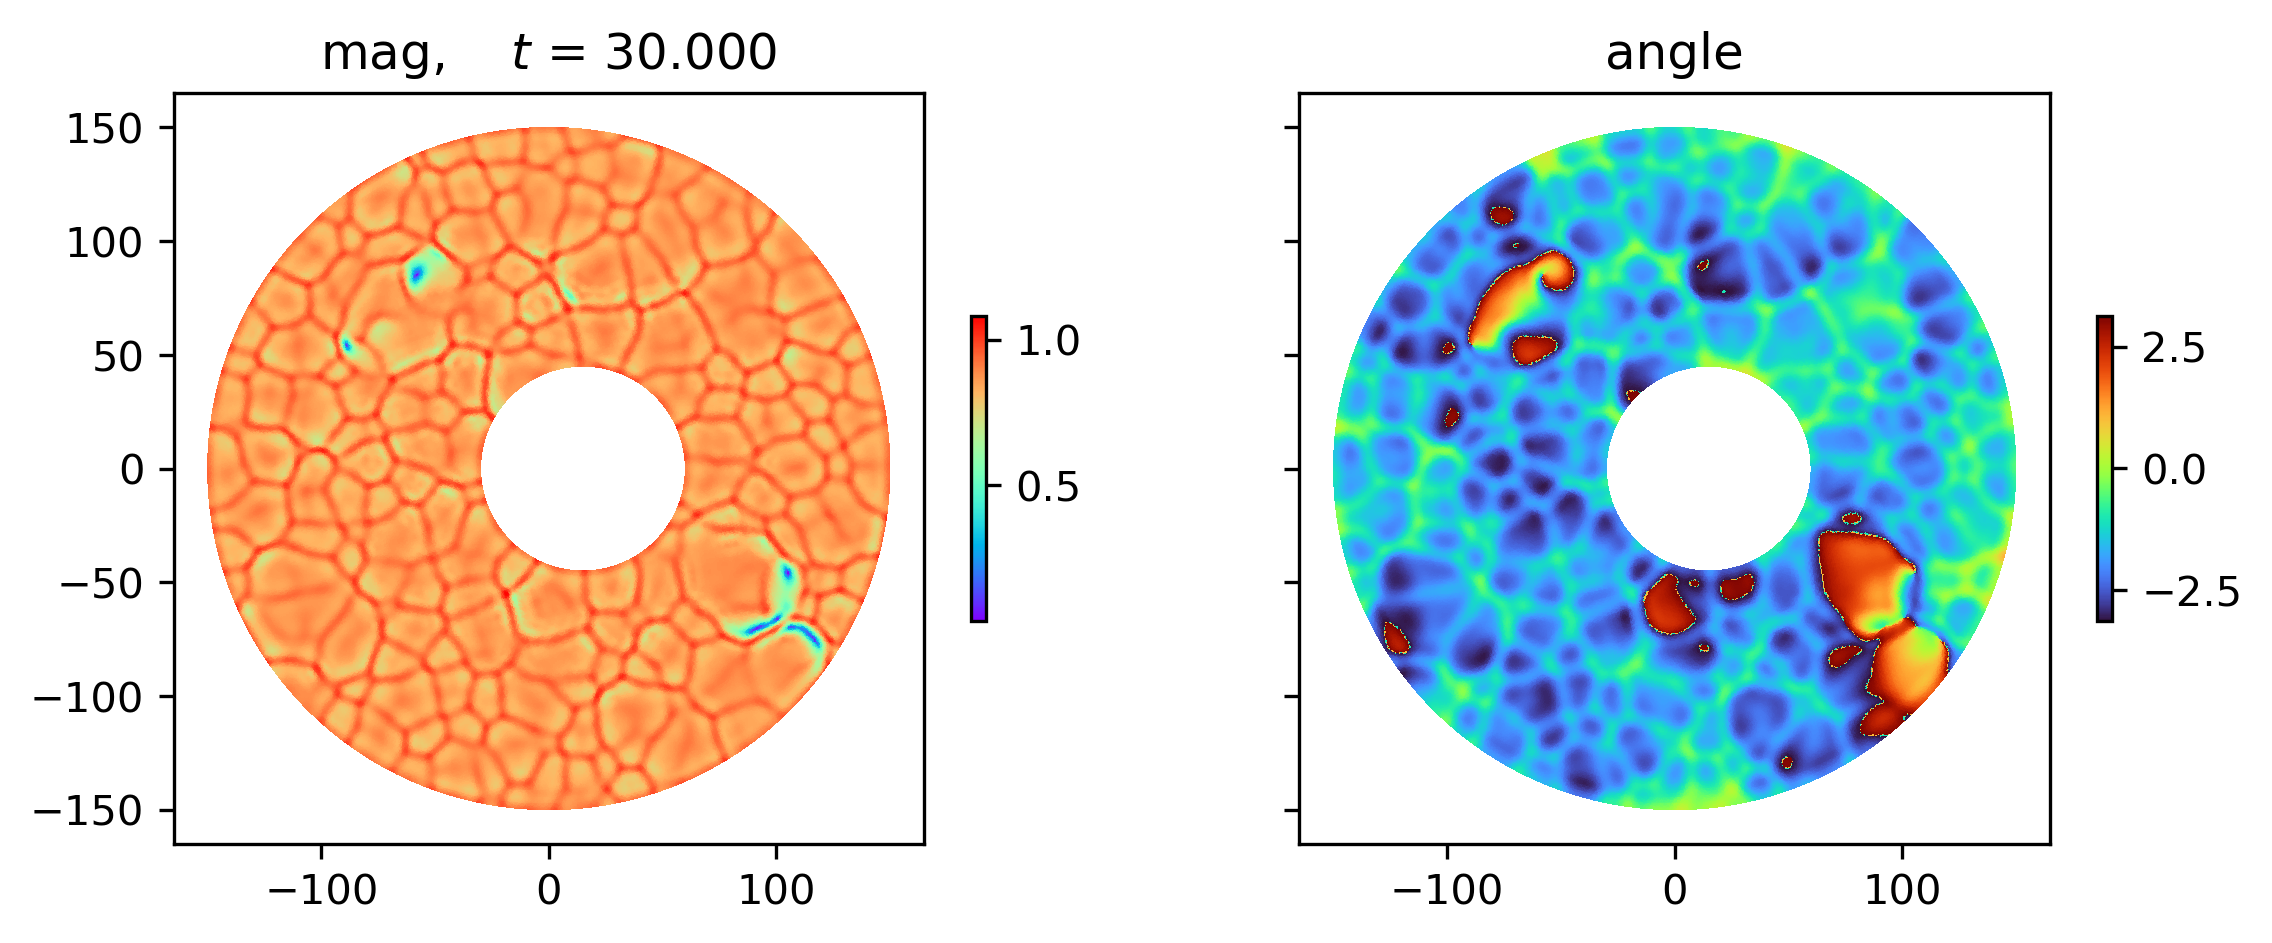

In [16]:
xv,yv,tri_tt, refiner = pts_tri(mesh) # get coordinates and triangles from the mesh
disp(mesh,gfu,30,xv,yv,tri_tt,refiner,'')  # worked but is not smooth and boundary does not look great